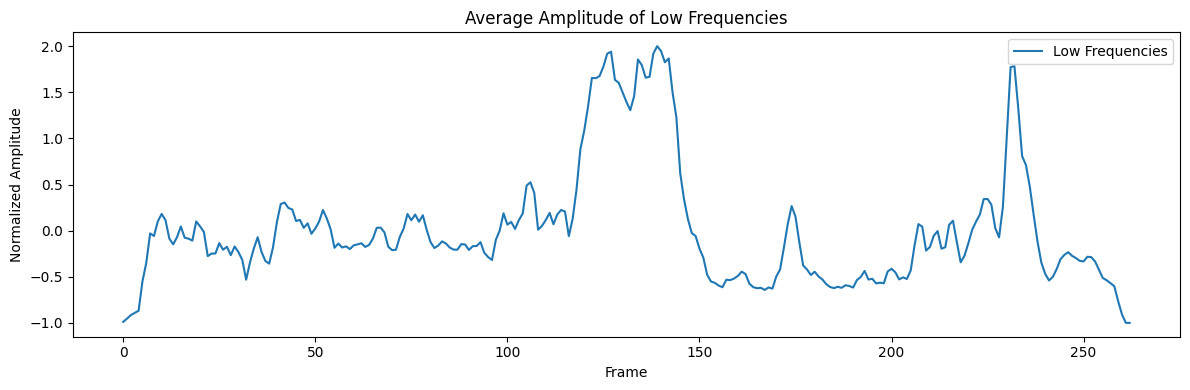

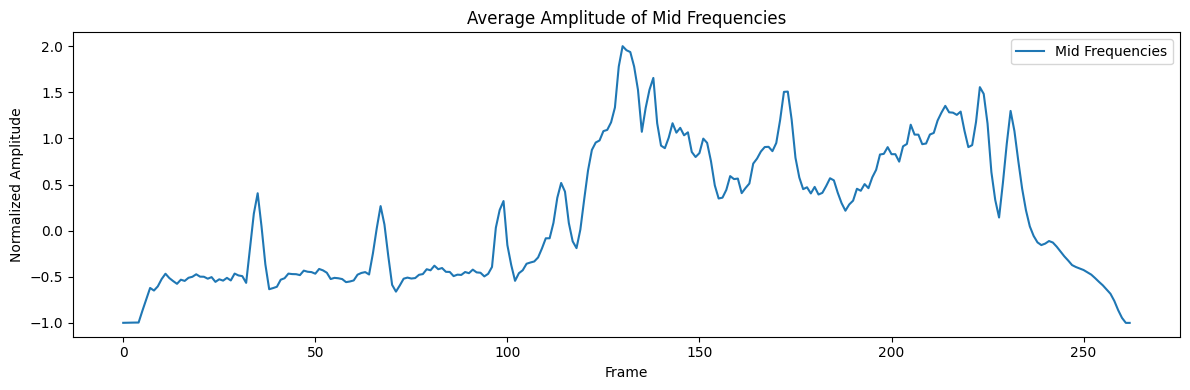

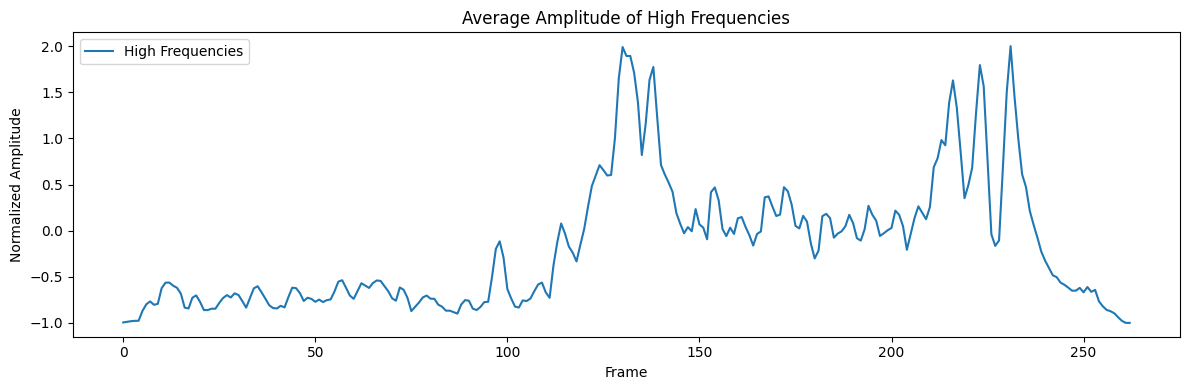

prompt:
{
    "0": "",
    "131": "",
    "252": ""
}
Файл успешно обновлен.


In [35]:
import numpy as np
import os, json
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
from pydub import AudioSegment

# Параметры диапазонов частот
frequency_ranges = {
    'Low Frequencies': (0, 250),
    'Mid Frequencies': (250, 2000),
    'High Frequencies': (2000, 20000),
}

# Параметры
seconds_to_analyze = 0 # 0 - 
frames_per_second = 12
filename = 'example.mp3'
deforum_settings_base = '_deforum_music_settings.txt'
deforum_settings_result = 'deforum_music_settings.txt'
human_hearing_min = 20  # Минимальная слышимая частота в Гц
human_hearing_max = 20000  # Максимальная слышимая частота в Гц

# Чтение  файла
def read_audio_file(filename):
    # Определяем расширение файла
    _, file_extension = os.path.splitext(filename)

    if file_extension.lower() == '.mp3':
        # Загрузка MP3 файла
        audio = AudioSegment.from_file(filename, format="mp3")
        
        # Преобразование аудио в массив numpy
        audio_data = np.array(audio.get_array_of_samples())

        # Переделываем стерео в моно при необходимости
        if audio.channels > 1:
            audio_data = audio_data.reshape((-1, audio.channels))
            audio_data = audio_data.mean(axis=1).astype(np.int16)

        sample_rate = audio.frame_rate
        
    elif file_extension.lower() == '.wav':
        # Чтение WAV файла
        sample_rate, audio_data = wavfile.read(filename)
        if audio_data.ndim > 1:
            audio_data = np.mean(audio_data, axis=1)

    else:
        raise ValueError("Unsupported file format")

    return sample_rate, audio_data

sample_rate, audio_data = read_audio_file(filename)

# Функция для полосового фильтра
def bandpass_filter(data, lowcut, highcut, sample_rate, order=5):
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Применяем фильтр ко всему диапазону длины файла
filtered_audio_data = bandpass_filter(audio_data, human_hearing_min, human_hearing_max, sample_rate)

if seconds_to_analyze>0:
    audio_data = filtered_audio_data[:sample_rate * seconds_to_analyze]
else:
    audio_data = filtered_audio_data

# Функция для расчета средних амплитуд для заданных диапазонов
def get_amplitude_by_range(frame_data, sample_rate, freq_range):
    n = len(frame_data)
    fft_result = np.fft.rfft(frame_data)
    fft_freqs = np.fft.rfftfreq(n, 1 / sample_rate)

    amplitudes = np.abs(fft_result)

    mask = (fft_freqs >= freq_range[0]) & (fft_freqs <= freq_range[1])
    data = np.abs(amplitudes[mask])
    return data

# Функция нормализации 
def normalize(data, min_value=0, max_value=1, window_size=1, inverted = False):
    # Обрезаем выбросы, превышающие 3 стандартных отклонения
    data_mean = np.mean(data)
    data_std = np.std(data)
    data = np.clip(data, data_mean - 3 * data_std, data_mean + 3 * data_std)
    if window_size>1:
        # Паддинг - дополнение массива справа (или слева) дубликатами крайних значений
        padding = np.repeat(data[-1], window_size - 1)
        extended_array = np.concatenate((data, padding))
    
        cumsum_vec = np.cumsum(np.insert(extended_array, 0, 0)) 
        smoothed_array = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    
        # Обрезка массива до исходной длины
        data = smoothed_array[:len(data)]

    # Минимальное и максимальное значения для корректной нормализации
    array_min, array_max = np.min(data), np.max(data)

    # Если минимальное и максимальное значения равны, используем min_value
    if array_min == array_max:
        normalized_array = np.ones_like(data) * min_value
    else:
        # В противном случае выполняем нормализацию
        normalized_array = (data - array_min) / (array_max - array_min)
        normalized_array = normalized_array * (max_value - min_value) + min_value
    
    if inverted:
        normalized_array = max_value - (normalized_array - min_value)
    return normalized_array

# Подготовка массива для амплитуд по частотным диапазонам
samples_per_frame = sample_rate // frames_per_second
amplitudes = {range_name: [] for range_name in frequency_ranges}

# Анализ амплитуд по частотным диапазонам
# Итерируем по аудиоданным с шагом в samples_per_frame семплов
for start in range(0, len(audio_data), samples_per_frame):
    end = start + samples_per_frame
    # Если мы на последнем сегменте и он не полный
    if end > len(audio_data):
        end = len(audio_data)  # Укорачиваем последний сегмент до конца массива
    frame_data = audio_data[start:end]
    for range_name, freq_range in frequency_ranges.items():
        amplitudes[range_name].append(
            np.mean(get_amplitude_by_range(frame_data, sample_rate, freq_range)))


# Отображение данных с нормализацией и сглаживанием
for range_name in frequency_ranges:
    norm_array = normalize(np.array(amplitudes[range_name]),-1,2,3)
    formatted_string = ", ".join(f"{index}: ({value:.2f})" for index, value in enumerate(norm_array))
    #print(formatted_string)
 
    plt.figure(figsize=(12, 4))
    plt.plot(norm_array, label=range_name)
    plt.title(f"Average Amplitude of {range_name}")
    plt.xlabel("Frame")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

all_peaks = []
for range_name in frequency_ranges:
    norm_array = normalize(np.array(amplitudes[range_name]),-1,1,3)
    peaks, _ = find_peaks(np.abs(np.diff(np.diff(norm_array))))
    all_peaks.extend((peak, norm_array[peak]) for peak in peaks)

selected_peaks = [0]
max_peaks = (len(audio_data) // sample_rate) // 4

# Сортируем все пики по величине в убывающем порядке
all_peaks.sort(key=lambda x: x[1], reverse=True)
for peak, value in all_peaks:
    if not selected_peaks:
        # Если ещё нет выбранных пиков, просто добавляем первый пик
        selected_peaks.append(peak)
    else:
        # Проверяем расстояние от текущего пика до всех уже выбранных пиков
        if all(abs(peak - selected_peak) >= frames_per_second*10 for selected_peak in selected_peaks):
            selected_peaks.append(peak)
    # Если мы достигли нужного количества пиков, прерываем цикл
    if len(selected_peaks) == max_peaks:
        break
selected_peaks.sort()
numbers_dict = {str(number): "" for number in selected_peaks}
numbers_json = json.dumps(numbers_dict, indent=4)
print('prompt:')
print(numbers_json)

def deforum_str(array):
    return ", ".join(f"{index}: ({value:.2f})" for index, value in enumerate(array))
# Чтение JSON из файла
with open(deforum_settings_base, 'r', encoding='utf-8') as f:
    deforum = json.load(f)
#for key, value in deforum.items():
#    print(f"The value of field '{key}' ")
deforum['soundtrack_path']=filename

for range_name in frequency_ranges:
    if range_name == 'Low Frequencies':
        deforum['max_frames']=len(np.array(amplitudes[range_name]))
        #print("cfg:")
        #print(deforum_str(normalize(np.array(amplitudes[range_name]),6,16,1)))
        deforum['cfg_scale_schedule'] = deforum_str(normalize(np.array(amplitudes[range_name]),6,16,1))
        #print("str:")
        x = normalize(np.array(amplitudes[range_name]),0.45,0.65,1,True)
        x[selected_peaks] *= 0.75
        #print(deforum_str(x))
        deforum['strength_schedule'] = deforum_str(x)
        #print("Translation Z:")
        #print(deforum_str(normalize(np.array(amplitudes[range_name]),-1,4,3)))
        deforum['translation_z'] = deforum_str(normalize(np.array(amplitudes[range_name]),-1,4,3))
    if range_name == 'Mid Frequencies':
        data_mean = np.mean(normalize(np.array(amplitudes[range_name]),-1.4,1.4,3,True))
        deforum['translation_x']=deforum_str(normalize(np.array(amplitudes[range_name]),-1.4,(1.4-data_mean*2),3,True))
        #print("Rotation 3D Y:")
        data_mean = np.mean(normalize(np.array(amplitudes[range_name]),-0.4,0.4,3))
        deforum['rotation_3d_y']=deforum_str(normalize(np.array(amplitudes[range_name]),-0.4,(0.4-data_mean*2),6))
        #print(deforum_str(normalize(np.array(amplitudes[range_name]),-0.4,0.4,3)))
    if range_name == 'High Frequencies':
        #print("Rotation 3D Z:")
        #print(deforum_str(normalize(np.array(amplitudes[range_name]),-0.4,0.4,3)))
        data_mean = np.mean(normalize(np.array(amplitudes[range_name]),-0.4,0.4,3))
        deforum['translation_y']=deforum_str(normalize(np.array(amplitudes[range_name]),-0.4,0.4-data_mean*2,3))
        deforum['rotation_3d_x']=deforum_str(normalize(np.array(amplitudes[range_name]),-0.4,(0.4-data_mean*2),6,True))

# Сохранение файла с обновленным значением поля
try:
    with open(deforum_settings_result, 'w', encoding='utf-8') as ff:
        json.dump(deforum, ff, ensure_ascii=False, indent=4)
    print("Файл успешно обновлен.")
except Exception as e:
    print(f"Произошла ошибка при записи файла: {e}")

In [31]:
# TODO change speed, based on bpm change
import librosa
import numpy as np

# Загрузка аудиофайла
y, sr = librosa.load('example.mp3')


# Рассчитываем производную онсетов (начал ударов), чтобы обнаружить смены темпа
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo_changes = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
dynamic_tempo = np.mean(tempo_changes, axis=1)

# Последовательность временных меток для кадров темпограммы
times = librosa.frames_to_time(np.arange(len(dynamic_tempo)), sr=sr)

# Найдём индексы кадров, где темп изменяется на значительную величину
change_points = np.abs(np.diff(dynamic_tempo)) > 0.5  # Выбрано пороговое значение 0.5 BPM

# Переводим индексы во временные метки и получаем их
change_times = times[:-1][change_points]
print("Ожидаемые временные точки изменения темпа:")
for change_time in change_times:
    print(f"{change_time:.2f} секунды")

Ожидаемые временные точки изменения темпа:
